# EDA of Correlations within Data

In [2]:
import h5py

import numpy   as np
import pandas  as pd
import seaborn as sns

import matplotlib.pyplot as plt
plt.style.use('../histograms.mplstyle')

import scipy.stats
import scipy.optimize

from matplotlib.ticker import ScalarFormatter

## Brief data inspection

In [3]:
# path to data file
FILE_NAME = "../data/RUN001231_channels.h5"

# get keys
f = h5py.File(FILE_NAME, "r")
keys = f.keys()

# build the dataset by concatenating all channels together
df = pd.concat(
    [
        pd.read_hdf(FILE_NAME, key=k, mode="r") for k in keys
    ],
    ignore_index=True
)

# rename columns
df = df.rename(columns={"CH":"ch", "HIT_DRIFT_TIME":"drift_time", "THETA":"theta"})

print(f"Shape: {df.shape}")
print(f'Features: {list(df.columns)}')

Shape: (236533, 4)
Features: ['ch', 'drift_time', 'm', 'theta']


### Visualization

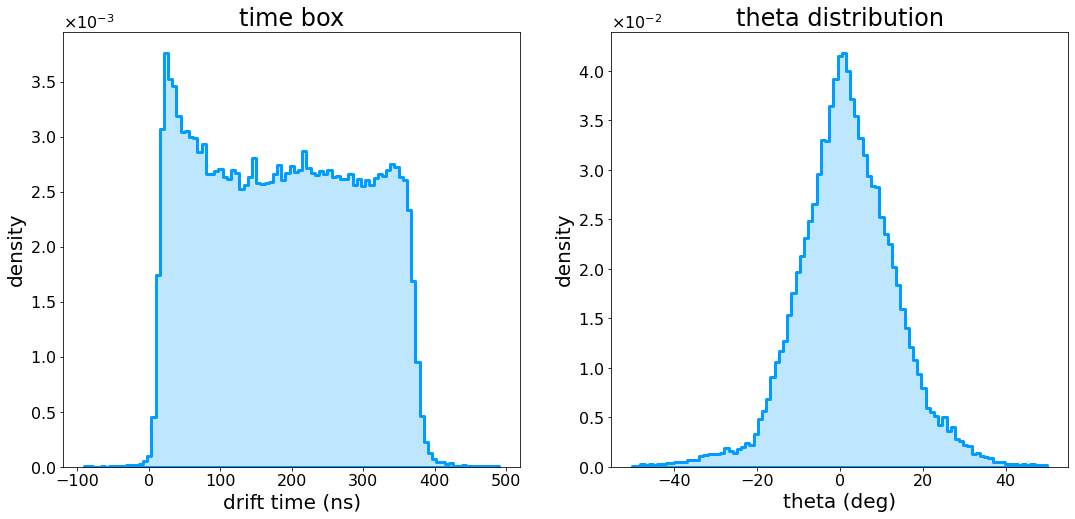

In [4]:
# BINS:
# drift time
dt_bins    = np.linspace(-90, 490, 100)
# theta
theta_bins = np.linspace(-50, 50 ,100)

fig, ax = plt.subplots(ncols=2, figsize=(18,8))

ax[0].set_title("time box")
ax[0].set_xlabel("drift time (ns)")
ax[0].set_ylabel("density")

ax[1].set_title("theta distribution")
ax[1].set_xlabel("theta (deg)")
ax[1].set_ylabel("density")

# drift time distribution
sns.histplot(
    x         = df.drift_time,
    bins      = dt_bins,
    stat      = "density",
    element   = "step",
    fill      = True,
    color     = "#aadeff",
    edgecolor = "#009cff",
    linewidth = 3,
    label     = "full dataset",
    ax        = ax[0]
)

# theta distribution
sns.histplot(
    x         = df.theta,
    bins      = theta_bins,
    stat      = "density",
    element   = "step",
    fill      = True,
    color     = "#aadeff",
    edgecolor = "#009cff",
    linewidth = 3,
    label     = "full dataset",
    ax        = ax[1]
)

# exponential y ticks
ax[0].yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
ax[0].ticklabel_format(axis = 'y', style = 'sci', scilimits = (0,0))
ax[1].yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
ax[1].ticklabel_format(axis = 'y', style = 'sci', scilimits = (0,0))

plt.show()

### Correlation coefficient


In [5]:
# correlation coefficient and its p-value
# note that I'm considering the absolute value of the angular feature:
# due to its simmetry I believe that we can get more statistical significance if we do so
r, p = scipy.stats.pearsonr(df.drift_time, np.abs(df.theta))
# set a confidence level at 5%
alpha = 0.05

print(f"Correlation coefficient between drift time and theta: {r:.5f}")
print(f"p-value = {p:.3e}")
print("Statistically significant:", "YES" if p < alpha else "NO")

Correlation coefficient between drift time and theta: -0.02834
p-value = 3.208e-43
Statistically significant: YES


### Covariance matrix

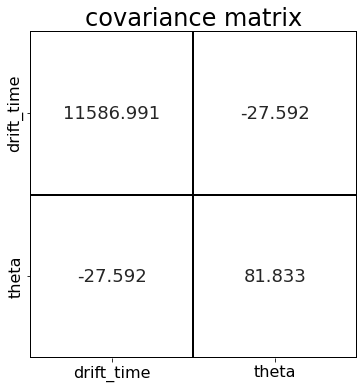

In [6]:
# covariance matrix
# note that I'm still considering the absolute value of theta
cov = np.cov([df.drift_time, np.abs(df.theta)])

textcolors = ["white", "black"]
ticklabels = ["drift_time","theta"]

fig, ax = plt.subplots(figsize=(6,6)) 
ax.set_title("covariance matrix")        

# plot of the covariance matrix
sns.heatmap(
    data        = cov,
    cmap        = ["white"],
    linecolor   = "black",
    linewidth   = 2,
    xticklabels = ticklabels, 
    yticklabels = ticklabels,
    robust      = True,
    annot       = True,
    fmt         = ".3f",
    annot_kws   = {"fontsize":18},
    cbar        = False,
    square      = True,
    ax          = ax
)

plt.show()

## Cutting the angular feature

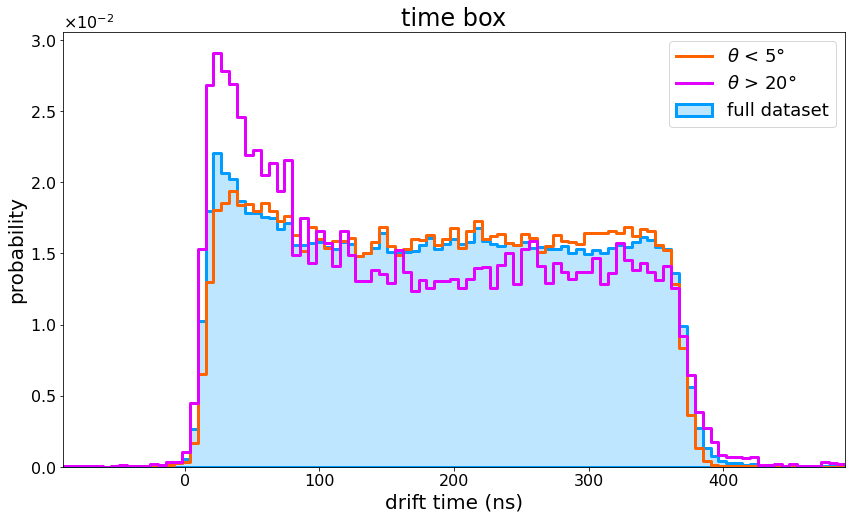

In [7]:
# binning drift time
bins = np.linspace(-90, 490, 100)
binwidth = bins[1] - bins[0]
bincenters = 0.5 * (bins[1:]+bins[:-1])

# CUTS:
# theta lower than |5°|
cut_1 = np.abs(df.theta) < 5
# theta higher than |20°|
cut_2 = np.abs(df.theta) > 20


fig, ax = plt.subplots()

ax.set_title("time box")
ax.set_xlabel("drift time (ns)")
ax.set_ylabel("probability")        # using probability instead of density

ax.set_xlim(bins[0], bins[-1])


# full dataset - drift time distribution
sns.histplot(
    x         = df.drift_time,
    bins      = bins,
    stat      = "probability",
    element   = "step",
    fill      = True,
    color     = "#aadeff",
    edgecolor = "#009cff",
    linewidth = 3,
    label     = "full dataset",
    ax        = ax
)

# theta lower than |5°| - drift time distribution
sns.histplot(
    x         = df[cut_1].drift_time,
    bins      = bins,
    stat      = "probability",
    element   = "step",
    fill      = False,
    color     = "#ff6300",
    linewidth = 3,
    label     = r"$\theta$ < 5°",
    ax        = ax
)

# theta higher than |20°| - drift time distribution
sns.histplot(
    x         = df[cut_2].drift_time,
    bins      = bins,
    stat      = "probability",
    element   = "step",
    fill      = False,
    color     = "#e200ff",
    linewidth = 3,
    label     = r"$\theta$ > 20°",
    ax        = ax
)



# exponential y ticks
ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
ax.ticklabel_format(axis = 'y', style = 'sci', scilimits = (0,0))

ax.legend(fontsize=18)

plt.show()

## Possible breakthrough: correlation with cuts

In [8]:
def normalize(hist):
    """normalizes an histogram such that the sum of bin heights is equal to 1

    Args:
        hist      (np.ndarray): bin heights
        
    Return:
        norm_hist (np.ndarray): normalized bin heights
    """
    return (hist / np.sum(hist))

In [9]:
# list of selected values of theta 
thetas = [
    5,
    10,
    15,
    20,
    25,
    30,
    35,
    40,
]

# create a list of masks (cuts) that slices data if theta is less than the selected value
low_cuts = [
    np.abs(df.theta) < theta for theta in thetas
]
# create a list of masks (cuts) that slices data if theta is higher than the selected value
high_cuts = [
    np.abs(df.theta) > theta for theta in thetas
]

In [15]:
# bin the time box for each (low) cut value 
hists         = [np.histogram(df[cut].drift_time, bins=bins)[0] for cut in low_cuts]
low_norms     = [np.sum(h) for h in hists]
low_hists     = [normalize(h) for h in hists]
low_err       = [np.sqrt(h/n) for h,n in zip(low_hists,low_norms)]
# find the maximum of the left edge peak 
# TO DO: use a gaussian fit to find the best estimate of the maximum
low_peaks     = [h.max() for h in low_hists]
low_peaks_err = [e.max() for e in low_err]      # HORRIBLE WAY TO SELECT THE CORRESPONDING UNCERTAINTY

# bin the time box for each (high) cut value 
hists          = [np.histogram(df[cut].drift_time, bins=bins)[0] for cut in high_cuts]
high_norms     = [np.sum(h) for h in hists]
high_hists     = [normalize(h) for h in hists]
high_err       = [np.sqrt(h/n) for h,n in zip(high_hists,high_norms)]
# find the maximum of the left edge peak 
# TO DO: use a gaussian fit to find the best estimate of the maximum
high_peaks     = [h.max() for h in high_hists]
high_peaks_err = [e.max() for e in high_err]    # HORRIBLE WAY TO SELECT THE CORRESPONDING UNCERTAINTY

low_hists[0].max()

0.01939682430179481

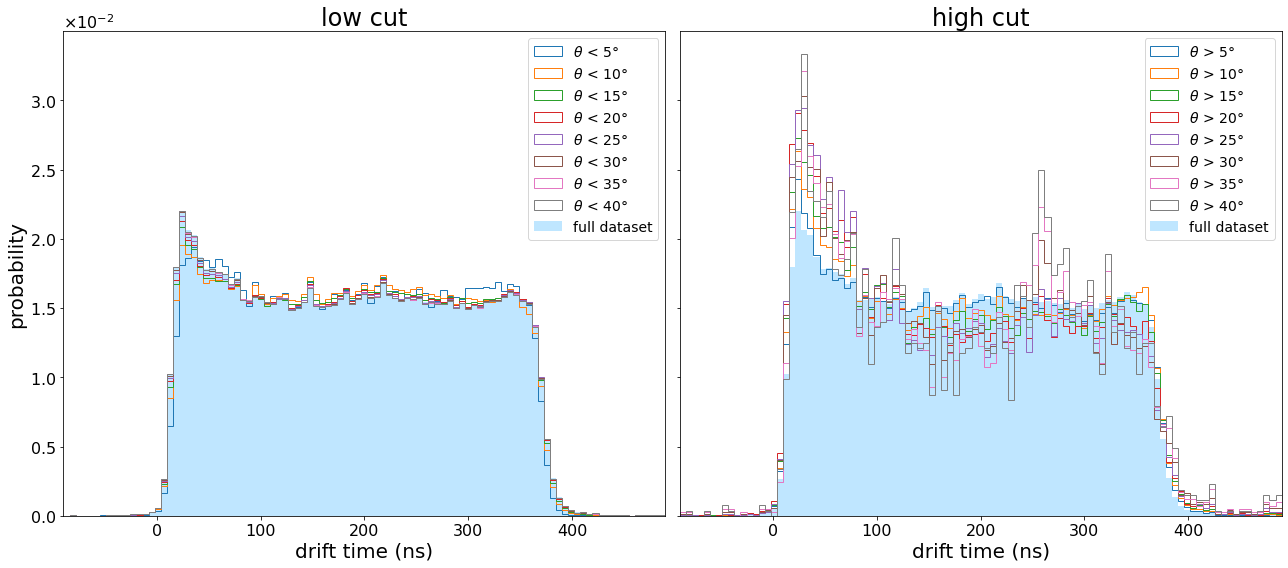

In [11]:
fig, ax = plt.subplots(ncols=2, sharex=True, sharey=True, figsize=(18,8))

ax[0].set_title("low cut")
ax[0].set_xlabel("drift time (ns)")
ax[0].set_ylabel("probability")
ax[1].set_title("high cut")
ax[1].set_xlabel("drift time (ns)")

# exponential y ticks
ax[0].yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
ax[0].ticklabel_format(axis = 'y', style = 'sci', scilimits = (0,0))

# x range
ax[0].set_xlim(bins[0], bins[-1])

# ------------------------------------
# FULL DATASETS FOR REFERENCE
sns.histplot(
    x         = df.drift_time,
    bins      = bins,
    stat      = "probability",
    element   = "step",
    fill      = True,
    color     = "#aadeff",
    edgecolor = "none",
    label     = "full dataset",
    ax        = ax[0]
)
sns.histplot(
    x         = df.drift_time,
    bins      = bins,
    stat      = "probability",
    element   = "step",
    fill      = True,
    color     = "#aadeff",
    edgecolor = "none",
    label     = "full dataset",
    ax        = ax[1]
)
# ------------------------------------

# low-cut time boxes
for h, theta in zip(low_hists, thetas):
    ax[0].hist(
        bins[:-1],
        bins=bins,
        weights=h,
        histtype="step",
        label=r"$\theta$ < "+str(theta)+"°"
    )

# high-cut time boxes
for h, theta in zip(high_hists, thetas):
    ax[1].hist(
        bins[:-1],
        bins=bins,
        weights=h,
        histtype="step",
        label=r"$\theta$ > "+str(theta)+"°"
    )


ax[0].legend(fontsize=14)
ax[1].legend(fontsize=14)

fig.tight_layout()
plt.show()


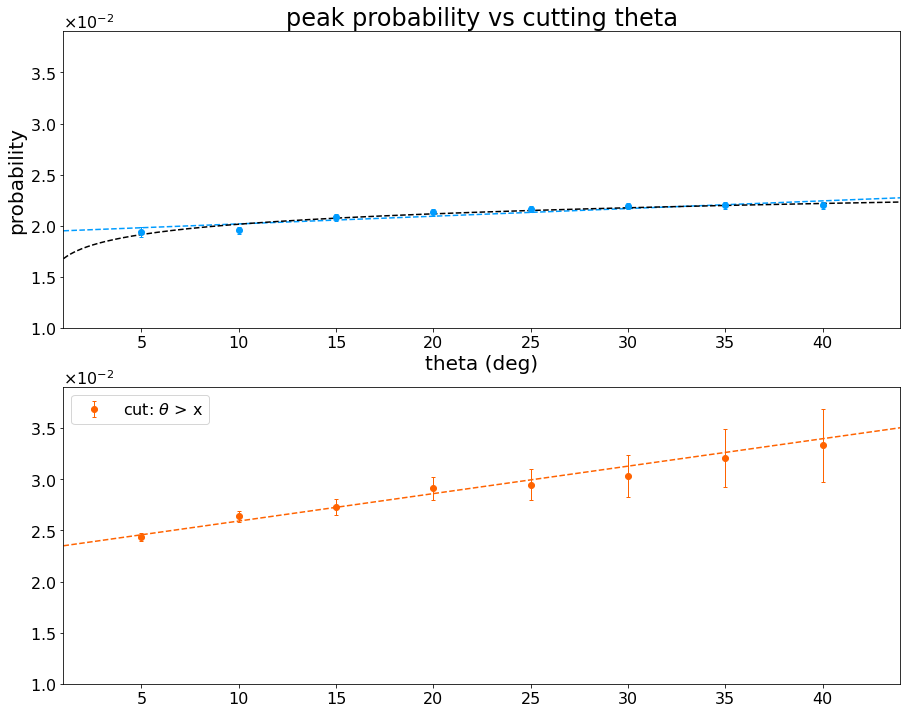


LOW CUT:
Correlation coefficient 0.92827
p-value = 8.74e-04
Statistically significant: YES

HIGH CUT:
Correlation coefficient 0.99105
p-value = 1.78e-06
Statistically significant: YES


In [12]:
# linear function
def lin(x, a, b): return a + b*x

# x grid for theta values (continuous, employed in plotting the fitted function)
theta_grid = np.linspace(thetas[0]-4, thetas[-1]+4, 500)

# fitting low cuts
low_par, _ = scipy.optimize.curve_fit(
    f=lin,
    xdata=thetas, 
    ydata=low_peaks,
    sigma=low_peaks_err, 
    absolute_sigma=True
)

# fitting high cuts
high_par, _ = scipy.optimize.curve_fit(
    f=lin,
    xdata=thetas, 
    ydata=high_peaks,
    sigma=high_peaks_err, 
    absolute_sigma=True
)

# TO DO: perform goodness-of-fit test (easy chi2 test)

fig, ax = plt.subplots(nrows=2, figsize=(15,12))

ax[0].set_title("peak probability vs cutting theta")
ax[0].set_xlabel("theta (deg)")
ax[0].set_ylabel("probability")

ax[0].set_xlim(theta_grid[0], theta_grid[-1])
ax[0].set_ylim(0.01,0.039)

ax[1].set_xlim(theta_grid[0], theta_grid[-1])
ax[1].set_ylim(0.01,0.039)


# exponential y ticks
ax[0].yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
ax[0].ticklabel_format(axis = 'y', style = 'sci', scilimits = (0,0))
ax[1].yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
ax[1].ticklabel_format(axis = 'y', style = 'sci', scilimits = (0,0))


# low-cut scatter
ax[0].errorbar(
    x          = thetas, 
    y          = low_peaks,
    yerr       = low_peaks_err,
    marker     = "o",
    color      = "#009cff",
    linestyle  = "none",
    elinewidth = 1, 
    capsize    = 2, 
    label      = r"cut: $\theta$ < x"
)
# low-cut fit
ax[0].plot(
    theta_grid, 
    lin(theta_grid, *low_par),
    linestyle = "dashed",
    color = "#009cff", 
)

# high-cut scatter
ax[1].errorbar(
    x          = thetas, 
    y          = high_peaks,
    yerr       = high_peaks_err,
    marker     = "o",
    color      =  "#ff6300",
    linestyle  = "none",
    elinewidth = 1, 
    capsize    = 2, 
    label      = r"cut: $\theta$ > x"
)
# high-cut fit
ax[1].plot(
    theta_grid, 
    lin(theta_grid, *high_par),
    linestyle = "dashed",
    color =  "#ff6300",
)

def log(x, A , B): return A * np.log(B*x) 
log_par, _ = scipy.optimize.curve_fit(
    f=log,
    xdata=thetas, 
    ydata=low_peaks,
    absolute_sigma=True
)
ax[0].plot(
    theta_grid, 
    log(theta_grid, *log_par),
    linestyle = "dashed",
    color = "black",
    label='logaritmirc' 
)


plt.legend(fontsize=16)
plt.show()


# -------- CORRELATION COEFFICIENTS
# set a confidence level at 5%
alpha = 0.05

# compute correlation coefficients
low_r,   low_p = scipy.stats.pearsonr(thetas, low_peaks)
high_r, high_p = scipy.stats.pearsonr(thetas, high_peaks)

print("\nLOW CUT:")
print(f"Correlation coefficient {low_r:.5f}")
print(f"p-value = {low_p:.2e}")
print("Statistically significant:", "YES" if low_p < alpha else "NO")
print("\nHIGH CUT:")
print(f"Correlation coefficient {high_r:.5f}")
print(f"p-value = {high_p:.2e}")
print("Statistically significant:", "YES" if high_p < alpha else "NO")